# 3.3. Batched training (tg.common.ml.batched_training)

## Overview of batched training process

Batched training is used when the training data is synthetic and so huge, that it cannot fit into memory. Examples are:

* Customer-article fit model. The features of customers and articles can fit into memory, but when we combine them by instances of articles, that were sent to customers, the data explode.
* Natural language processing. When, for instance, processing the sentence of N words, we may wish to construct the training samples so that network predicts $W_i$ word from $(W_1,\ldots,W_{i-1})$ for $i\in[1, N]$. In this case, the data also explode.

Current version of batched training process is *not* dealing with the situation, when the initial data themselves are too big to fit the memory. If this is the case, the current strategy is to get a bigger AWS instance. If it's not feasible, the approach can theoretically be adopted for this case as well.

In batched training, the data are synthesized in _batches_, one after another, and therefore memory is not overused. Consequently, the model must support the iterative training. In our use cases this is always pytorch network, but of course the architecture is not limited to neural networks or some particular implementation of them.

## Data Bundles

As a dataframe is the "all-inclusive" object containing the data for single-frame training, _data bundle_ is such for batched training. The bundle is a set of dataframes, that contains all the data required for batches synthesis.

You normally start batched training by creating such bundle, and we will do the same for the Titanic dataset. We will do it in an overcomplicated way, that is totally unnessesary for this particular task, but will allow us to demonstrate available batching techniques. We will separate the available information in Titanic dataset into two parts: information about ticket and information about customer.

In [1]:
import pandas as pd
df = pd.read_csv('titanic.csv')
df = df.set_index('PassengerId')
for c in ['Pclass','SibSp','Parch','Survived']:
    df[c] = df[c].astype(float)

In rare cases Ticket number does not fully determine the Fare or Embarked column, but we will ignore the exceptions.

In [2]:
tdf = df[['Ticket','Pclass','Fare','Embarked']].drop_duplicates()
bad_tickets = tdf.groupby('Ticket').size()
bad_tickets = bad_tickets.loc[bad_tickets>1]
tdf.loc[tdf.Ticket.isin(bad_tickets.index)].sort_values('Ticket')

,Ticket,Pclass,Fare,Embarked
PassengerId,,,,
271,113798,1.0,31.0000,S
843,113798,1.0,31.0000,C
139,7534,3.0,9.2167,S
877,7534,3.0,9.8458,S
270,PC 17760,1.0,135.6333,S
326,PC 17760,1.0,135.6333,C


So the ticket dataframe is:

In [3]:
ticket_df = df[['Ticket','Pclass','Fare','Embarked']].drop_duplicates().drop_duplicates('Ticket').set_index('Ticket')
ticket_df.head()

,Pclass,Fare,Embarked
Ticket,,,
A/5 21171,3.0,7.2500,S
PC 17599,1.0,71.2833,C
STON/O2. 3101282,3.0,7.9250,S
113803,1.0,53.1000,S
373450,3.0,8.0500,S


Name is unique across passengers, so we will use it as an index.

In [4]:
df.groupby('Name').size().sort_values(ascending=False).head()

Name
Abbing, Mr. Anthony             1
Nysveen, Mr. Johan Hansen       1
Nicholson, Mr. Arthur Ernest    1
Nicola-Yarred, Master. Elias    1
Nicola-Yarred, Miss. Jamila     1
dtype: int64

In [5]:
passenger_df = df[['Name','Sex','Age','SibSp','Parch']].set_index('Name')
passenger_df.head()

,Sex,Age,SibSp,Parch
Name,,,,
"Braund, Mr. Owen Harris",male,22.0,1.0,0.0
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1.0,0.0
"Heikkinen, Miss. Laina",female,26.0,0.0,0.0
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0
"Allen, Mr. William Henry",male,35.0,0.0,0.0


Now, we will build the frame that sums up the information:

In [6]:
index_df = df[['Name','Ticket','Cabin','Survived']].copy()
index_df.Survived = index_df.Survived.astype(float)
index_df.head()

,Name,Ticket,Cabin,Survived
PassengerId,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,NaN,0.0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,1.0
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,1.0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,1.0
5,"Allen, Mr. William Henry",373450,NaN,0.0


In [7]:
from tg.common.ml import batched_training as bt

bundle = bt.DataBundle(
    index = index_df,
    passengers = passenger_df,
    tickets = ticket_df
)

Of course, such complicated structure of this bundle is totally unnesessary in this case, and we could just use the entire original dataframe as an index frame. 

Still, it shows how to bundle data together: we use different data sources (e.g. different table from SQL) without any joining or transformation, and bind them together by index frame.

Let's also save this bundle for later use:

In [8]:
bundle.save('temp/bundle')

### Indexed Data Bundle

We see that one of the dataframes is "special" in the sense that it carries a top-level information that binds together other frames. This special role is reflected in `IndexedDataBundle` class, that contains `index_frame` and `bundle`. 

In [9]:
ibundle = bt.IndexedDataBundle(bundle.index, bundle)

## Batcher

Batch is a dictionary with several dataframes that is used as a direct argument to the model. They have to be aligned (in our case, the tickets should correspond to the respective passengers), and transformed.

The pipeline to produce batches from `IndexedDataBundle` is:
1. Separate `index_frame` into parts. Each row of `index_frame` defines one individual training sample, so the batch is defined by a set of the rows, so to say the subset of `index_frame`. This part is done by `TrainingStrategy` class. 
2. For each part, pull the data from `data_frames` of the bundle and apply transformers to them. The resulting dataframes are then returned as a dictionary, which is then fed to the model for training or prediction. This is done by one or many `Extractor`.

The size of the batch is determined by the parameter `batch_size`. The rule of thumb is to select the biggest possible `batch_size` that still does not overfill the memory of the machine.

*Tip:* to avoid confusion between extracting with `Extractors` and transforming with `dft`, remember simple rule: transformation is about _columns_, while extraction is about _rows_.

### Training Strategy

Simple batcher strategy simply separates the frame into subsequent parts of the desired size. Let's create a test dataframe we will use to demonstrate different strategies:

In [10]:
test_df = pd.DataFrame(dict(x=list(range(5))))
test_df

,x
0,0
1,1
2,2
3,3
4,4


`SimpleBatchingStrategy` simply separates the dataframe into the consequent subsets of appropriate size

In [11]:
strategy = bt.SimpleBatcherStrategy()
batch_count = strategy.get_batch_count(3,test_df)
print(batch_count)
for i in range(batch_count):
    print(list(strategy.get_batch(3,test_df,i)))

2
[0, 1, 2]
[3, 4]


We also have `PriorityRandomBatcherStrategy`, that randomly samples rows from index frame, paying attention to the indicated weights. That can be used to balance underrepresented samples in the dataset. All of the generated batches will be of the `batch_size`, even if it's greater that dataframe size.

In [12]:
strategy = bt.PriorityRandomBatcherStrategy('x',deduplicate=False)
batch = strategy.get_batch(10000, test_df, 0)
test_df.loc[batch].groupby('x').size()

x
1     982
2    1994
3    2967
4    4057
dtype: int64

The Titanic dataset's balance is okayish

In [13]:
ibundle.index_frame.groupby('Survived').size()

Survived
0.0    549
1.0    342
dtype: int64

But let's use PriorityRandomBatcherStrategy nevertheless. First, we need to compute the priority of each row, which reflects imbalance. We have a function to do so:

In [14]:
import copy

ibundle_fixed = copy.deepcopy(ibundle)
ibundle_fixed.index_frame['priority'] = bt.PriorityRandomBatcherStrategy.make_priorities_for_even_representation(
    df = ibundle_fixed.index_frame,
    column = 'Survived'
)
ibundle_fixed.index_frame.head()

,Name,Ticket,Cabin,Survived,priority
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,NaN,0.0,0.001821
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,1.0,0.002924
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,1.0,0.002924
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,1.0,0.002924
5,"Allen, Mr. William Henry",373450,NaN,0.0,0.001821


We see that survived passengers have slighly greater chances to make it to the batch.

**NOTE**: you probably wouldn't do it like that in the real training. The thing is, you don't want to complicate data bundle creation with a model-specific steps like this one. We only do it to demonstrate, how the final Batcher is going to perform. We will show how to do this step properly a little later


By the way, a good rule of thumb here is: **if you need data bundle when initializing the model, you're doing something wrong!** This is true for Single-Frame training as well, but it is especially true for batcher training, because even in our use cases some datasets are too big to be opened on our laptops, and you can only open them at the remote training instance.

### Extractors

Extractors look at the index, provided by `BatcherStrategy`, extract data from bundle and apply transformer. In this demo, as well as in many real application, it's done by joining the dataframes with the `index_frame`. This is implemented in `PlainExtractor` class.

Let's define a small sample to see how the results of the extractors look like:

In [15]:
ibundle_sample = ibundle_fixed.change_index(ibundle_fixed.index_frame.iloc[10:13])
ibundle_sample.index_frame

,Name,Ticket,Cabin,Survived,priority
PassengerId,,,,,
11,"Sandstrom, Miss. Marguerite Rut",PP 9549,G6,1.0,0.002924
12,"Bonnell, Miss. Elizabeth",113783,C103,1.0,0.002924
13,"Saundercock, Mr. William Henry",A/5. 2151,NaN,0.0,0.001821


The most simple case is when data extracted from index itself, which is the case for the label:

In [16]:
label_extractor = bt.PlainExtractor.build(name='labels').apply(take_columns='Survived')
label_extractor.extract(ibundle_sample)

,Survived
PassengerId,
11,1.0
12,1.0
13,0.0


Cabin also should be extracted from the index, but this time we will need a transformer.

**NOTE**: you don't need to `fit` anything manually! Again, we do it just to demonstrate how the classes work. All the fitting is done internally, you only need to define the instances of the corresponding classes. 

In [17]:
from tg.common.ml import dft

tfac = dft.DataFrameTransformerFactory.default_factory

cabin_extractor = bt.PlainExtractor.build(name='cabin').index().apply(transformer=tfac(), take_columns='Cabin')
cabin_extractor.fit(ibundle_fixed)
cabin_extractor.extract(ibundle_sample)

,Cabin_C23 C25 C27,Cabin_G6,Cabin_B96 B98,Cabin_F2,Cabin_C22 C26,Cabin_E101,Cabin_F33,Cabin_D,Cabin_C78,Cabin_B57 B59 B63 B66,...,Cabin_C123,Cabin_C124,Cabin_C125,Cabin_C126,Cabin_D36,Cabin_C2,Cabin_C83,Cabin_E25,Cabin_OTHER,Cabin_NULL
PassengerId,,,,,,,,,,,,,,,,,,,,,
11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**Note** that `tfac` here is not an object, but a function that constructs the object. This is because we will have several extractors, and each of them have to have their own transformer! This is a common error and in fact `PlainExtractor` makes a deepcopy of transformer to circumvent the problem if one appears due to the oversight.

To extract features from other dataframes, we will need to add `join` method.

In [18]:
passenger_extractor = (bt.PlainExtractor.build('passengers')
                       .index()
                       .join(frame_name='passengers', on_columns='Name')
                       .apply(transformer=tfac())
                      )
passenger_extractor.fit(ibundle_fixed)
passenger_extractor.extract(ibundle_sample)

,Age,SibSp,Parch,Age_missing,Sex_male,Sex_female
PassengerId,,,,,,
11,-1.770360,0.432793,0.767630,False,0.0,1.0
12,1.949591,-0.474545,-0.473674,False,0.0,1.0
13,-0.668153,-0.474545,-0.473674,False,1.0,0.0


Notice that the resulting dataframe is indexed the same way the `ibundle_sample.index_frame` is.

Let's repeat this for tickets as well.

In [19]:
ticket_extractor = (bt.PlainExtractor.build(name='tickets')
                    .index()
                    .join(frame_name='tickets', on_columns='Ticket')
                    .apply(transformer=tfac())
                   )
ticket_extractor.fit(ibundle_fixed)
ticket_extractor.extract(ibundle_sample)

,Pclass,Fare,Embarked_S,Embarked_C,Embarked_Q,Embarked_NULL
PassengerId,,,,,,
11,0.827377,-0.312156,1.0,0.0,0.0,0.0
12,-1.566107,-0.113831,1.0,0.0,0.0,0.0
13,0.827377,-0.486320,1.0,0.0,0.0,0.0


Now, we have 4 extractors, but we really do not need so much dataframes in batches. We only need have features and labels. So we will unite the feature extractors into one:

In [20]:
feature_extractor = bt.CombinedExtractor('features',[cabin_extractor, passenger_extractor, ticket_extractor])
feature_extractor.fit(ibundle_fixed)
feature_extractor.extract(ibundle_sample)

,cabin_Cabin_C23 C25 C27,cabin_Cabin_G6,cabin_Cabin_B96 B98,cabin_Cabin_F2,cabin_Cabin_C22 C26,cabin_Cabin_E101,cabin_Cabin_F33,cabin_Cabin_D,cabin_Cabin_C78,cabin_Cabin_B57 B59 B63 B66,...,passengers_Parch,passengers_Age_missing,passengers_Sex_male,passengers_Sex_female,tickets_Pclass,tickets_Fare,tickets_Embarked_S,tickets_Embarked_C,tickets_Embarked_Q,tickets_Embarked_NULL
PassengerId,,,,,,,,,,,,,,,,,,,,,
11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.767630,False,0.0,1.0,0.827377,-0.312156,1.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.473674,False,0.0,1.0,-1.566107,-0.113831,1.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.473674,False,1.0,0.0,0.827377,-0.486320,1.0,0.0,0.0,0.0


### Batcher

Now we are ready to define the Batcher:

In [21]:
batcher = bt.Batcher(
    extractors = [feature_extractor, label_extractor],
    batching_strategy = bt.PriorityRandomBatcherStrategy('priority')
)

Let's take a look at the batch produced

In [22]:
batch_size = 50
batch = batcher.fit_extract(batch_size, ibundle_fixed)
batch

So, batch is of type `DataBundle`, and contains index, features, and labels. 

The batch is balanced

In [23]:
batch['labels'].groupby('Survived').size()

Survived
0.0    30
1.0    17
dtype: int64

**Note:** due to the technical reasons, `PlainExtractor`, as well as other extractors, do not support extraction in case when the output of `BatchingStrategy` contains duplicated rows. This is why by default, `PriorityRandomBatcherStrategy` deduplicates them, and therefore cannot return more rows that there are in the bundle. We consider fixing this issue in the future releases, but since the datasets are normaly (much) bigger than batches, not with the high priority.

In [24]:
test_batcher = bt.Batcher(
    extractors = [feature_extractor, label_extractor],
    batching_strategy = bt.PriorityRandomBatcherStrategy('priority')
)
test_batch = test_batcher.fit_extract(batch_size, ibundle_fixed)
test_batch['labels'].groupby('Survived').size()

Survived
0.0    22
1.0    27
dtype: int64

### Minibatches

Batch size has the following effects on training:
  1. It defines amount of memory, consumed by the training instance
  1. It defines the velocity of training process, as smaller batches have bigger overheads (per record)
  1. It defines the quality of neural network training
  
[1] and [2] suggest we pick the biggest batch size that fits to the instance memory. However, the quality is often better with much smaller batches.

This is why minibatches are introduced. Once the heavy work of joining and transforming is done and the batch is computed, it can be further subdivided to _mini-batches_.

In [25]:
mini_batch_indices = batcher.get_mini_batch_indices(mini_batch_size = 10, batch = batch)
mini_batch = batcher.get_mini_batch(index = mini_batch_indices[0], batch = batch)
mini_batch['index'].shape

(10, 5)

## Model Handler

`ModelHandler` is another important component of the batched training. It handles the model, namely:

* Instantiates the model. For neural network, this step is non-trivial, because we don't really know how much features we have before we fit all the extractors. Thus, we don't really know how much inputs network should have. To instantiate the model, a sample batch is created and passed to the initialization method to address this.
* Implements training on one batch. Again, this is more complicated in case of neural networks than just calling a `fit` method. 
* Implements the prediction. For different tasks, we interpret the network's output differently. In Single Frame Training, we had Evaluation to address this. Still, here the options are more plentiful, so it's moved into `ModelHandler` as well.

In `tg.common.ml.batched_training.factories` there is a generic definition for such `ModelHandler` that we will cover in the corresponding demo. Here, we will define `ModelHandler` from scratch, to demonstrate its logic.


In [26]:
import torch


class TorchNetwork(torch.nn.Module):
    def __init__(self, sizes):
        super(TorchNetwork, self).__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            
    def forward(self, input):
        X = torch.tensor(input.astype(float).values).float()
        for layer in self.layers:
            X = layer(X)
            X = torch.sigmoid(X)
        return X
        
        
class TorchHandler(bt.BatchedModelHandler):
    def instantiate(self, task, input):
        sizes = [input['features'].shape[1], 10, 1]
        self.network = TorchNetwork(sizes)
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=0.5)
        self.loss = torch.nn.MSELoss()

    def train(self, input):
        X, y = input['features'], input['labels']
        self.optimizer.zero_grad()
        output = self.network(X)
        targets = torch.tensor(y.values).float()
        loss = self.loss(output, targets)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def predict(self, input):
        X, y = input['features'], input['labels']
        output = self.network(X)
        output = output.flatten().tolist()
        df = pd.DataFrame(dict(predicted=output, true=y[y.columns[0]]))
        return df
    


## Training task

Aside from `ModelHandler` and `Batcher`, `BatcherTrainingTask` is initialized with the classes, already covered in the previous demo: 
* `splitter` to split the index frame to test and train dataset,
  * For batch training, the splitter _must_ return just one split. K-fold is not supported here, because the time of one model training is simply too long, and in this case we suggest the parallel training.
    * The use case for multiple splits _could_ be a model, than trains on first N months and predicts N+1-th, then updates on N+1-th month and predicts N+2-th, etc. We are considering implementing this in the next versions.
  * For batch traiing, the train set is not evaluated, because, again, it takes too much time for the big datasets. So what we will do is adding additional `display` subset, which is part of training, but on which the metrics are computed.
* `metrics_pool` to compute metrics
* `artificiers` to inject arbitrary code into training

Also, there is a `settings` object that contains some self-explainatory fields.

In [27]:
from sklearn.metrics import roc_auc_score


def build_splitter():
    return bt.CompositionSplitter(
        bt.FoldSplitter(test_size=0.2),
        bt.FoldSplitter(test_size=0.2, decorate=True, test_name='display')
    )


task = bt.BatchedTrainingTask(
    splitter = build_splitter(),
    batcher = batcher,
    model_handler=TorchHandler(),
    metric_pool = bt.MetricPool().add_sklearn(roc_auc_score),
    settings = bt.TrainingSettings(epoch_count=1)
)
task.settings.batch_size=100

result = task.run(ibundle_fixed)

2022-12-28 14:21:10.014697 INFO: Training starts. Info: {}


2022-12-28 14:21:10.016047 INFO: Ensuring/loading bundle. Bundle before:


2022-12-28 14:21:10.016617 INFO: Bundle loaded
{'index': {'shape': (891, 5), 'index_name': 'PassengerId', 'columns': ['Name', 'Ticket', 'Cabin', 'Survived', 'priority'], 'index': [1, 2, 3, 4, 5, '...']}, 'passengers': {'shape': (891, 4), 'index_name': 'Name', 'columns': ['Sex', 'Age', 'SibSp', 'Parch'], 'index': ['Braund, Mr. Owen Harris', 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'Heikkinen, Miss. Laina', 'Futrelle, Mrs. Jacques Heath (Lily May Peel)', 'Allen, Mr. William Henry', '...']}, 'tickets': {'shape': (681, 3), 'index_name': 'Ticket', 'columns': ['Pclass', 'Fare', 'Embarked'], 'index': ['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450', '...']}}


2022-12-28 14:21:10.017190 INFO: Index frame is set to index, shape is (891, 5)


2022-12-28 14:21:10.017786 INFO: Skipping late initialization


2022-12-28 14:21:10.018319 INFO: Preprocessing bundle by batcher


2022-12-28 14:21:10.023948 INFO: Splits: train 712, test 179, display 143


2022-12-28 14:21:10.024546 INFO: New training. Instantiating the system


2022-12-28 14:21:10.025671 INFO: Fitting the transformers


2022-12-28 14:21:10.073160 INFO: Instantiating model


2022-12-28 14:21:10.074611 INFO: Initialization completed


2022-12-28 14:21:10.075486 INFO: Epoch 0 of 1


2022-12-28 14:21:10.075927 INFO: Training: 0/8


2022-12-28 14:21:10.103902 INFO: Training: 1/8


2022-12-28 14:21:10.128179 INFO: Training: 2/8


2022-12-28 14:21:10.156215 INFO: Training: 3/8


2022-12-28 14:21:10.180618 INFO: Training: 4/8


2022-12-28 14:21:10.205398 INFO: Training: 5/8


2022-12-28 14:21:10.230677 INFO: Training: 6/8


2022-12-28 14:21:10.257123 INFO: Training: 7/8


2022-12-28 14:21:10.282654 INFO: test: 0/2


2022-12-28 14:21:10.308441 INFO: test: 1/2


2022-12-28 14:21:10.334269 INFO: display: 0/2


2022-12-28 14:21:10.358629 INFO: display: 1/2


2022-12-28 14:21:10.387787 INFO: ###roc_auc_score_test:0.4130434782608696


2022-12-28 14:21:10.388229 INFO: ###roc_auc_score_display:0.43268817204301074


2022-12-28 14:21:10.388711 INFO: ###loss:0.2608289998024702


2022-12-28 14:21:10.389460 INFO: ###iteration:0


As you can see, `TrainingTasks` logs quite extensively on the initialization process, so in case of error it's relativaly easy to understand the source of error. 

Now, let's disable `Logger` and run training for the longer time:

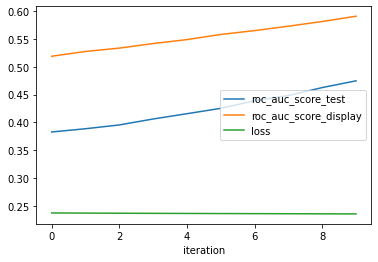

In [28]:
from tg.common import Logger
Logger.disable()

task = bt.BatchedTrainingTask(
    splitter = build_splitter(),
    batcher = batcher,
    model_handler=TorchHandler(),
    metric_pool = bt.MetricPool().add_sklearn(roc_auc_score),
    settings = bt.TrainingSettings(epoch_count=10)
)

result = task.run(ibundle_fixed)

pd.DataFrame(result['output']['history']).set_index('iteration').plot()
pass

Feel free to explore other fields of `result` as well. We hope the name of the fields are quite self-explanatory.

Training can be continued, in this case history persists and the models are not recreated.

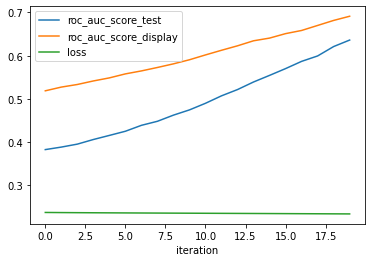

In [29]:
task.settings.continue_training=True
result = task.run(ibundle_fixed)
pd.DataFrame(result['output']['history']).set_index('iteration').plot()
pass

You don't have to use the same bundle for continuation. So it's totally feasible to tune our models with newly available data instead of retrain them from scratch every time. 


### Late initialization

Late initialization allows you to:
* alter data in the bundle when they were loaded
* initialize or modify arbitrary fields of the task, based on loaded data

The main use case is that the model might require some tweaking depending on the input data, or the input data might require tweaking itself. For instance, in our case, it's a row priority, which we hacked into the bundle while discussing `BatchingStrategy`. 

The proper way is to compute this field in late initialization. This method accepts task, bundle and environment (for logging purposes), and can modify any of those.

Actually, late initialization is also implemented in single-frame training, but for this one we don't really have the use cases yet.

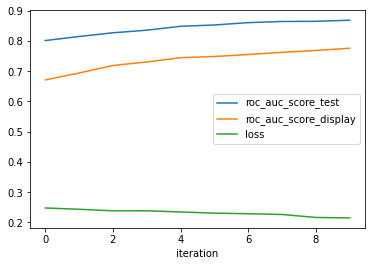

In [30]:
def late_initialization(task, ibundle):
    ibundle.index_frame['priority'] = bt.PriorityRandomBatcherStrategy.make_priorities_for_even_representation(
        ibundle.index_frame,
        'Survived'
    )


task = bt.BatchedTrainingTask(
    splitter = build_splitter(),
    batcher = batcher,
    model_handler=TorchHandler(),
    metric_pool = bt.MetricPool().add_sklearn(roc_auc_score),
    settings = bt.TrainingSettings(epoch_count=10, batch_size=100),
    late_initialization=late_initialization
)

result = task.run(ibundle)
pd.DataFrame(result['output']['history']).set_index('iteration').plot()
pass

### Prediction

In many cases, the model can be directly applied to the data to make predictions. To do this, simply construct the DataBundle with the data for prediction and apply method predict to it.

In [31]:
prediction = task.predict(ibundle.change_index(ibundle.index_frame.iloc[:5]))
prediction

,predicted,true
PassengerId,,
1,0.385275,0.0
2,0.664146,1.0
3,0.462648,1.0
4,0.632161,1.0
5,0.384694,0.0


In some cases, you don't really need the model to predict anything, because, for instance, you're actually interested in scores that are produced as the intermediate values in your network. In this case, you will need to write the prediction procedure yourself. Keep in mind that:

* Batcher is as essensial for the prediction as is model. Batcher contains all the extractors that were fitted during the training, and the model simply won't work without them.
* There is some additional initialization of the bundle that may be needed, so observe the `predict` method for exact sequence of the initialization steps.

## Troubleshooting

Batched training is a lot more complicated process than single-frame training. Generally, there are two major sources of errors:
* Something is wrong with batchers/extractors
* Something is wrong with the network process: dimensions/shapes do not match, data types are unexpected, etc.

### Separating batching from model

Errors in batcher can be debugged by separately running extractors and evaluating their results, as we did in this demo. Errors in network, however, are harder to track, as the network is fed with the batcher's output. To debug the network, we offer the access to initialization and batch creation separately from training.

This method will allow you to initialize everything and get the batch:

In [32]:
task = bt.BatchedTrainingTask(
    splitter = build_splitter(),
    batcher = batcher,
    model_handler=TorchHandler(),
    metric_pool = bt.MetricPool().add_sklearn(roc_auc_score),
    settings = bt.TrainingSettings(epoch_count=10)
)
batch, temp_data = task.generate_sample_batch_and_temp_data(ibundle_fixed)

This batch then can be used on different levels to debug network and handler:

In [33]:
task.model_handler.network(batch['features'])[:5]

tensor([[0.4334],
        [0.4201],
        [0.4227],
        [0.4231],
        [0.4233]], grad_fn=<SliceBackward>)

In [34]:
task.model_handler.predict(batch).head()

,predicted,true
PassengerId,,
874,0.433400,0.0
833,0.420091,0.0
105,0.422657,0.0
612,0.423145,0.0
284,0.423349,1.0


Temp data also contains lots of the information, useful for debugging, such as splits

In [35]:
temp_data.__dict__

{'original_ibundle': <tg.common.ml.batched_training.data_bundle.IndexedDataBundle at 0x7f8c4038d640>,
 'env': <tg.common.ml.training_core.arch.TrainingEnvironment at 0x7f8bac086a90>,
 'split': <tg.common.ml.training_core.splitter.DataFrameSplit at 0x7f8ba8f45a30>,
 'first_iteration': 0,
 'iteration': 0,
 'losses': [],
 'epoch_begins_at': None,
 'train_bundle': None,
 'result': None,
 'batch': None,
 'mini_batch_indices': None,
 'mini_batch': None}

### Debug mode

`BatchingTrainingTask` has a `debug` argument, which forces the task to keep the intermediate data as a field of the class (`temp_data` from the previous section). **Never** do it in production, as the intermediate data also contain the bundle, so pickling the task (which is an artefact of the training) will be impossible with any real data. 

However, with toy datasets such as we have, it's very useful to look at the intermediate dataframes when debugging errors. For instance, let's check if the `test` and `display` splits are related to the train split the way we expect:

In [36]:
task = bt.BatchedTrainingTask(
    splitter = build_splitter(),
    batcher = batcher,
    model_handler=TorchHandler(),
    metric_pool = bt.MetricPool().add_sklearn(roc_auc_score),
    settings = bt.TrainingSettings(epoch_count=1),
    late_initialization=late_initialization,
    debug = True
)
task.run(ibundle)
pass

We can, for instance, observe the modification of the bundle, performed in the `late_initialization`:

In [37]:
task.data_.original_ibundle.index_frame.head()

,Name,Ticket,Cabin,Survived,priority
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,NaN,0.0,0.001821
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,1.0,0.002924
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,1.0,0.002924
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,1.0,0.002924
5,"Allen, Mr. William Henry",373450,NaN,0.0,0.001821


Or, we may ensure that the splits are consistant with our expectations:

In [38]:
(
    task.data_.result.test_splits['test'].isin(task.data_.result.train_split).mean(),
    task.data_.result.test_splits['display'].isin(task.data_.result.train_split).mean()
)

(0.0, 1.0)

Or, if we're interested in the current batch:

In [39]:
task.data_.batch['index'].groupby('Survived').size()

Survived
0.0    439
1.0    273
dtype: int64

In general, if the training fails at some step, there is a good chance that the input for this step is stored in `data_` field, so you may debug the failing step separately.

## Advanced techniques 

### Minibatches 

As mentioned earlier, sometimes it makes sense to subdivide batch into smaller mini-batches, to optimize both the efficiency of the training and the quality of the result. This can be achieved by using `BatchedTrainingTask.settings.batch_size` and `mini_batch_size` fields.

Typically, we opt for the following strategy:
  * Finding the biggest `batch_size` that fits the network
  * Setting something like 200 to `mini_batch_size`, maybe additionally checking values 20 and 2000. In our experience, the network is not sensitive to this parameter as long as it stays within reasonable range.
  
### Multi-task bundles

Sometimes we may pose different tasks with essentially same data, e.g., different prediction tasks based on the same NLP corpus. In this case, you make generate several index frames with different names, and set `BatchedTrainingTask.index_name_in_bundle` when running the task.


### Heavy precomputing in extractors

Sometimes `Extractor` needs to perform a heavy computation. For instance, in NLP task we may want to compute for each word it's frequency in the text. Or, in customer-to-article relation, we may want to compute an average performance of the article in the previous months. Doing so for each batch would be impractical, it would be much better to do once.

However, doing so in `fit` is wrong for two reasons:
* Storing data in the model will increase its size and generally break the border between data and model, which we try to maintain very hard in TG.
* When predicting, `fit` obviously should not be called, but such intermediate data should be computed.

Therefore, `preprocess_bundle` is available in the `Extractor`, where such computation may be performed.


### Hyperparameter tuning

Implemented exactly the same way as in single-frame training. 

In practice, we never used this functionality, nor did we debug it with hyperopt. We opted for manual tuning in the following way:
  * there is a `build_task` method that accepts essential parameters
  * we run nested loop over parameters, create task for every combination and run the task in the cloud

